# Planet to planet low-thrust

In this tutorial we show the use of the {class}`pykep.trajopt.direct_pl2pl` to find a low-thrust trajectory connecting two moving planets. 

The decision vector for this class, compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0$ as a MJD2000, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [24]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

We start defining the problem data.

In [25]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.6
isp = 3000
veff = isp * pk.G0

# Source and destination planets
earth = pk.planet_to_keplerian(
    pk.planet(pk.udpla.jpl_lp(body="EARTH")), when=pk.epoch(5000)
)

mars = pk.planet_to_keplerian(
    pk.planet(pk.udpla.jpl_lp(body="MARS")), when=pk.epoch(5000)
)

venus = pk.planet_to_keplerian(
    pk.planet(pk.udpla.jpl_lp(body="venus")), when=pk.epoch(5000)
)

# Initial state
ms = 1500.0

# Number of segments
nseg = 30

We here instantiate two different versions of the same UDP (User Defined Problem), with analytical gradients and without. 

For the purpose of this simple notebook we choose a relatively simple Earth to Mars transfer with an initial $V_{\infty}$ of 3 km/s.

In [26]:
udp_nog = pk.trajopt.direct_pl2pl(
        pls=earth,
        plf=mars,
        ms=ms,
        mu=pk.MU_SUN,
        max_thrust=max_thrust,
        veff=veff,
        t0_bounds=[7360, 8300.0],
        tof_bounds=[100.0, 350.0],
        mf_bounds=[1000., ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=0.6,
        mass_scaling=ms,
        r_scaling=pk.AU,
        v_scaling=pk.EARTH_VELOCITY,
        with_gradient=False,
)

udp_g = pk.trajopt.direct_pl2pl(
        pls=earth,
        plf=mars,
        ms=ms,
        mu=pk.MU_SUN,
        max_thrust=max_thrust,
        veff=veff,
        t0_bounds=[7360, 8300.0],
        tof_bounds=[100.0, 350.0],
        mf_bounds=[1000., ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=0.6,
        mass_scaling=ms,
        r_scaling=pk.AU,
        v_scaling=pk.EARTH_VELOCITY,
        with_gradient=True,
)

## Analytical performances of the analytical gradient

And we take a quick look at the performances of the analytical gradient with respect to the numerically computed one.

In [27]:
# We need to generste a random chromosomes compatible with the UDP where to test the gradient.
prob_g = pg.problem(udp_g)
pop_g = pg.population(prob_g, 1)

First the analytical gradient:

In [28]:
%%timeit
udp_g.gradient(pop_g.champion_x)

388 μs ± 10.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Then a simple numerical gradient based on finite differences:

In [29]:
%%timeit
pg.estimate_gradient(udp_g.fitness, pop_g.champion_x)

4.84 ms ± 50.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Then a higher order numerical gradient:

In [30]:
%%timeit
pg.estimate_gradient_h(udp_g.fitness, pop_g.champion_x)

14.4 ms ± 48.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The analytical gradient its exact and faster, seems like a no brainer to use it. 

In reality, the effects on the optimization technique used are not straightforward, making the option to use numerical gradients still interesting in some, albeit rare, cases.

## Solving the low-thrust transfer

We define (again) the optimization problem, and set a tolerance for *pagmo* to be able to judge the relative value of two individuals. 

:::{note}
This tolerance has a different role from the numerical tolerance set in the particular algorithm chosen to solve the problem and is only used by the *pagmo* machinery to decide outside the optimizer whether the new proposed indivdual is better than what was the previous *champion*.

In [31]:
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6

... and we define an optimization algorithm.

In [ ]:
snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-11)

#uda = pg.nlopt("slsqp")
algo = pg.algorithm(uda)

We solve the problem from random initial guess ten times and only save the result if a feasible solution is found (as defined by the criterias above)

In [33]:
masses = []
xs = []
for i in range(10):
    pop_g = pg.population(prob_g, 1)
    pop_g = algo.evolve(pop_g)
    if(prob_g.feasibility_f(pop_g.champion_f)):
        print(".", end="")
        masses.append(pop_g.champion_x[1])
        xs.append(pop_g.champion_x)
    else:
        print("x", end ="")
print("\nBest mass is: ", np.max(masses))
print("Worst mass is: ", np.min(masses))
best_idx = np.argmax(masses)

.x...x.x..
Best mass is:  1234.15683652
Worst mass is:  1000.00240866


And we plot the trajectory found:

In [34]:
udp_g.pretty(xs[best_idx])


Low-thrust NEP transfer
Departure: earth(jpl_lp)(K)
Arrival: mars(jpl_lp)(K)

Launch epoch: 7451.99905 MJD2000, a.k.a. 2020-05-26T23:58:37.777239
Arrival epoch: 7801.99905 MJD2000, a.k.a. 2021-05-11T23:58:37.777239
Time of flight (days): 350.00000 

Launch DV (km/s) 0.00000000 - [-0.0,-0.0,-0.0]
Arrival DV (km/s) 0.00000000 - [-0.0,-0.0,-0.0]
Final mass (kg): 1234.1568365174858

Details on the low-thrust leg: 
Number of segments: 30
Number of fwd segments: 18
Number of bck segments: 12
Maximum thrust: 0.6
Central body gravitational parameter: 1.3271244004127942e+20
Specific impulse: 29419.949999999997

Time of flight: 30240000
Initial mass: 1500
Final mass: 1234.1568365174858
State at departure: [[-61940343629.2697, -138342786962.2452, 4315832.209158619], [26703.174217445237, -12284.734893133622, 0.38324263734277736]]
State at arrival: [[-154574671931.75818, 191750935543.9109, 7812362370.575885], [-17947.983008640604, -13143.524741070263, 165.21826805857714]]
Throttles values: [0.9149

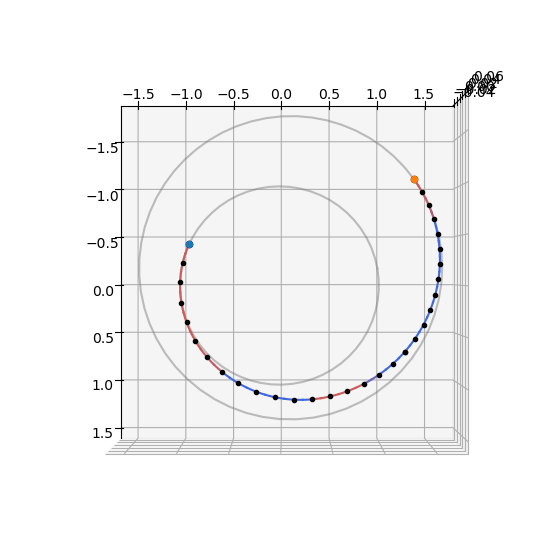

In [35]:
ax = udp_g.plot(xs[best_idx], show_gridpoints=True)
ax.view_init(90, 0)

## Graident vs no gradient
We here take a look at the difference in solving the problem using the analytical gradient and not using it.
To do so we solve the same problem starting from 100 different initial guesses using both versions and compare.

In [37]:
from tqdm import tqdm

cpu_nog = []
cpu_g = []

fail_g = 0
fail_nog = 0

prob_g = pg.problem(udp_g)
prob_nog = pg.problem(udp_nog)
prob_g.c_tol = 1e-6
prob_nog.c_tol = 1e-6

for i in tqdm(range(100)):
    pop_g = pg.population(prob_g, 1)
    pop_nog = pg.population(prob_nog)
    pop_nog.push_back(pop_g.champion_x)

    start = time.time()
    pop_g = algo.evolve(pop_g)
    end = time.time()
    if not prob_g.feasibility_f(pop_g.champion_f):
        fail_g += 1
    else: # We only record the time for successfull attempts
        cpu_g.append(end - start)

    start = time.time()
    pop_nog = algo.evolve(pop_nog)
    end = time.time()
    if not prob_nog.feasibility_f(pop_nog.champion_f):
        fail_nog += 1
    else: # We only record the time for successfull attempts
        cpu_nog.append(end - start)

print(f"Gradient: {np.median(cpu_g):.4e}s")
print(f"No Gradient: {np.median(cpu_nog):.4e}s")

print(f"\nGradient (n.fails): {fail_g}")
print(f"No Gradient (n.fails): {fail_nog}")

100%|██████████| 100/100 [05:15<00:00,  3.16s/it]

Gradient: 1.0034e+00s
No Gradient: 1.9059e+00s

Gradient (n.fails): 13
No Gradient (n.fails): 46


Text(0, 0.5, 'N. occurrences')

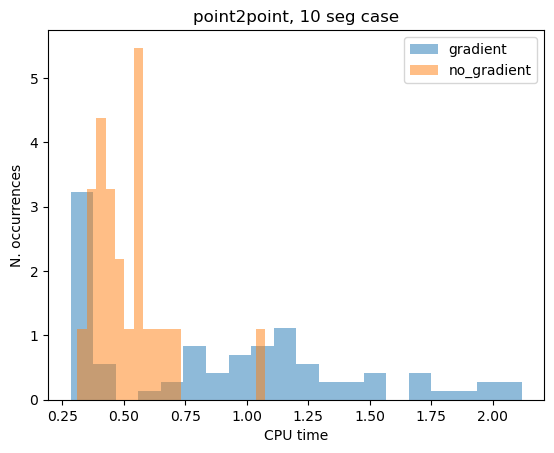

In [38]:
cpu_g = np.array(cpu_g)
cpu_nog = np.array(cpu_nog)
plt.hist(cpu_g[cpu_g < 2.2], bins=20, label="gradient", density=True, alpha=0.5)
plt.hist(cpu_nog[cpu_nog < 1.2], bins=20, label="no_gradient", density=True, alpha=0.5)
# plt.xlim([0,0.15])
plt.legend()
plt.title("point2point, 10 seg case")
plt.xlabel("CPU time")
plt.ylabel("N. occurrences")